In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [49]:
%%R
library(phyloseq)
library(doParallel)
library(ggplot2)
library(vegan)
library(RColorBrewer)
library(plyr)
library(gridExtra)

Loading required package: grid


In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq_snorm = transform_sample_counts(physeq, function(x) x / sum(x))

In [23]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, days), all at once
# I create a list of the variables I want to run the ordination by
days = list(Day1=0, Day12=1, Day82=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Day == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.days = ldply(days, ord)

Run 0 stress 0.1382542 
Run 1 stress 0.1382585 
... procrustes: rmse 0.0008237659  max resid 0.004332188 
*** Solution reached
Run 0 stress 0.05178293 
Run 1 stress 0.05178286 
... New best solution
... procrustes: rmse 3.671902e-05  max resid 0.0001250134 
*** Solution reached
Run 0 stress 0.1202765 
Run 1 stress 0.1390257 
Run 2 stress 0.1447241 
Run 3 stress 0.143156 
Run 4 stress 0.1283773 
Run 5 stress 0.1202765 
... New best solution
... procrustes: rmse 3.088025e-05  max resid 0.0001433005 
*** Solution reached


In [24]:
%%R
# Set up computer to do parallel computing
registerDoParallel(cores=10)

# This is me running an ordination for a bunch of different sets (here, amendments), all at once
# I create a list of the variables I want to run the ordination by
amdmts = list(Soil=0, PyOM=1, Stover=2)

# Pull out the sample data from the physeq object
md = sample_data(physeq_snorm)

# Create a function that prunes samples where the Day is equal to the value from her list created above, for the physeq.
ord = function(x) {
    ps = prune_samples((md$Amdmt == x), physeq_snorm)
# Then, on this pruned set of data for just one day, perform a weighted unifrac ordination
    NMDS = ordinate(ps,
                method = "NMDS",
                distance = "unifrac",
                weighted = TRUE,
                fast = TRUE,
                parallel = TRUE)
# Then do the plot_ordination command to get just the data frame, and report that, for the first 3 axes
    p.nmds = plot_ordination(ps, NMDS, axes = c(1,2), justDF = TRUE)
    return(p.nmds)
}

# With the function  created above, we then stick together (vertically), the results from the dataframe,
# using the days string as the input that gets run through the ord function each time.
# Now, you could make plots on each day separately, by using the facet_wrap parameter in ggplot,
# And the ordinations for each day would have been calculated independently, rather than across the whole experiment
ord.NMDS.amdmts = ldply(amdmts, ord)

Run 0 stress 0.1547195 
Run 1 stress 0.1547153 
... New best solution
... procrustes: rmse 0.002157425  max resid 0.01203982 
Run 2 stress 0.1547704 
... procrustes: rmse 0.002936673  max resid 0.01612656 
Run 3 stress 0.1547167 
... procrustes: rmse 0.001782303  max resid 0.01008949 
Run 4 stress 0.1547169 
... procrustes: rmse 0.0001871306  max resid 0.0009601235 
*** Solution reached
Run 0 stress 0.157755 
Run 1 stress 0.1491843 
... New best solution
... procrustes: rmse 0.04643979  max resid 0.1828235 
Run 2 stress 0.1726952 
Run 3 stress 0.1600433 
Run 4 stress 0.1514852 
Run 5 stress 0.1783393 
Run 6 stress 0.1600431 
Run 7 stress 0.1783423 
Run 8 stress 0.149185 
... procrustes: rmse 0.0001347155  max resid 0.0007419026 
*** Solution reached
Run 0 stress 0.04874676 
Run 1 stress 0.3812506 
Run 2 stress 0.05188698 
Run 3 stress 0.05455656 
Run 4 stress 0.05458495 
Run 5 stress 0.05216027 
Run 6 stress 0.05262941 
Run 7 stress 0.05197844 
Run 8 stress 0.05237075 
Run 9 stress 0.0

In [28]:
%%R
# Computing the weighted unifrac distance matrix and NMDS in parallel
registerDoParallel(cores=10)
ord.NMDS.full = ordinate(physeq_snorm, method = "NMDS", distance = "unifrac", weighted = TRUE, fast = TRUE, parallel = TRUE)
NMDS.full = plot_ordination(physeq_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)

Run 0 stress 0.09095929 
Run 1 stress 0.09896906 
Run 2 stress 0.09640065 
Run 3 stress 0.09565117 
Run 4 stress 0.09507967 
Run 5 stress 0.0921489 
Run 6 stress 0.09094761 
... New best solution
... procrustes: rmse 0.0007150692  max resid 0.004430389 
*** Solution reached


In [29]:
%%R
head(NMDS.full)

            NMDS1        NMDS2 Plants DayAmdmt Amdmt ID Day
S009 -0.028882615  0.014237784      1       01     1  D   0
S204 -0.003632771 -0.001605205      1       21     1  D   2
S112 -0.010446172 -0.015037124      0       11     1  B   1
S247  0.019273806  0.014371651      0       22     2  F   2
S026 -0.020699773  0.017458210      0       00     0  A   0
S023 -0.035273418  0.019351290      1       00     0  C   0


Error in layout_base(data, vars, drop = drop) : 
  At least one layer must contain all variables used for facetting
In addition: Warning message:
In UniFrac(physeq, ...) :
  Randomly assigning root as -- OTU.7868 -- in the phylogenetic tree in the data you provided.


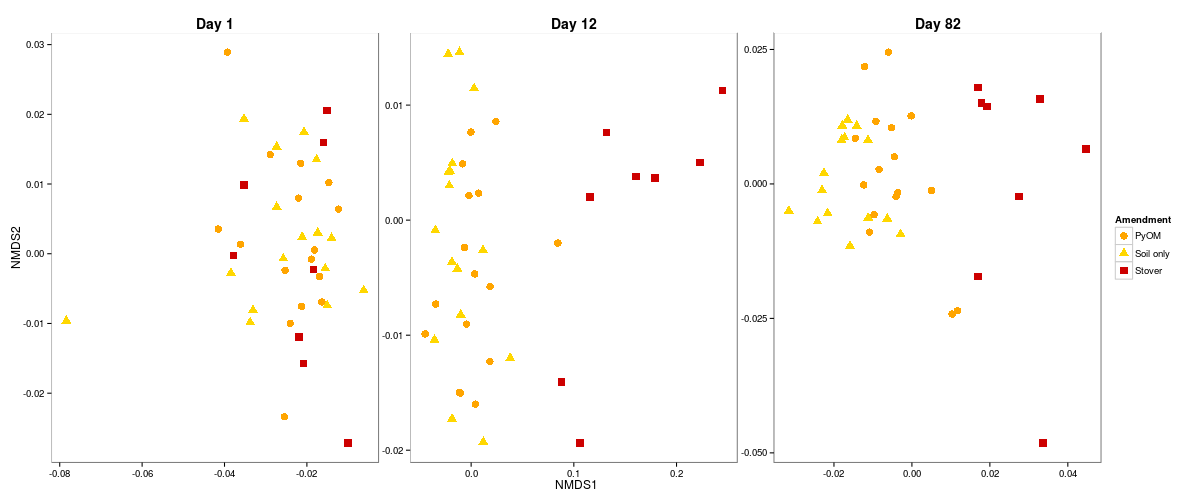

In [52]:
%%R -h 500 -w 1200
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend("Amendment"), shape = guide_legend("Amendment"))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales = "free")
# The axis scales could be all optimized individually
#p = p + facet_wrap(~DayName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byDay = p
p

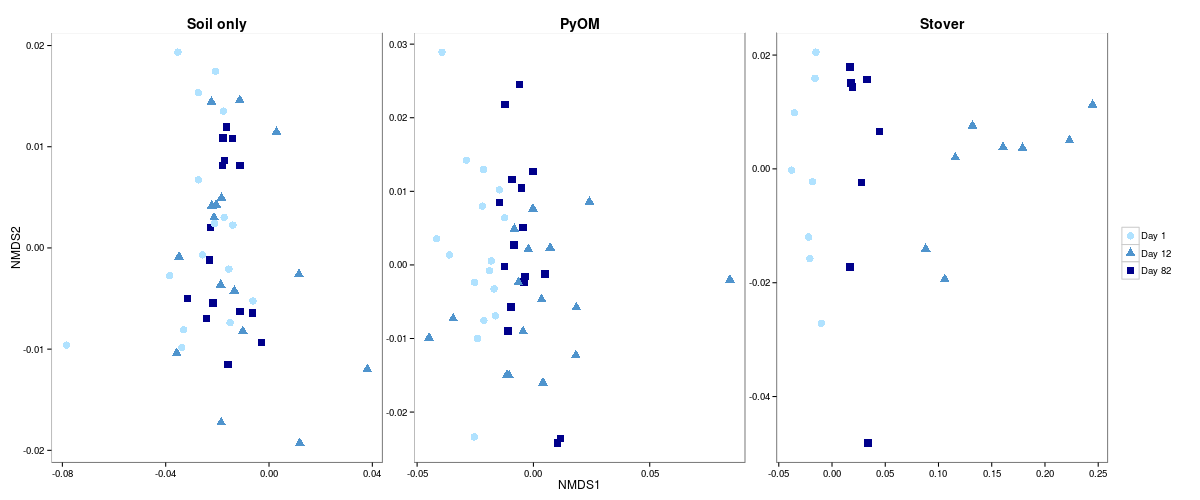

In [48]:
%%R -h 500 -w 1200
D <- NMDS.full
# Sets the relevant ordination

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~AmdmtName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.full.byAmdmt = p
p

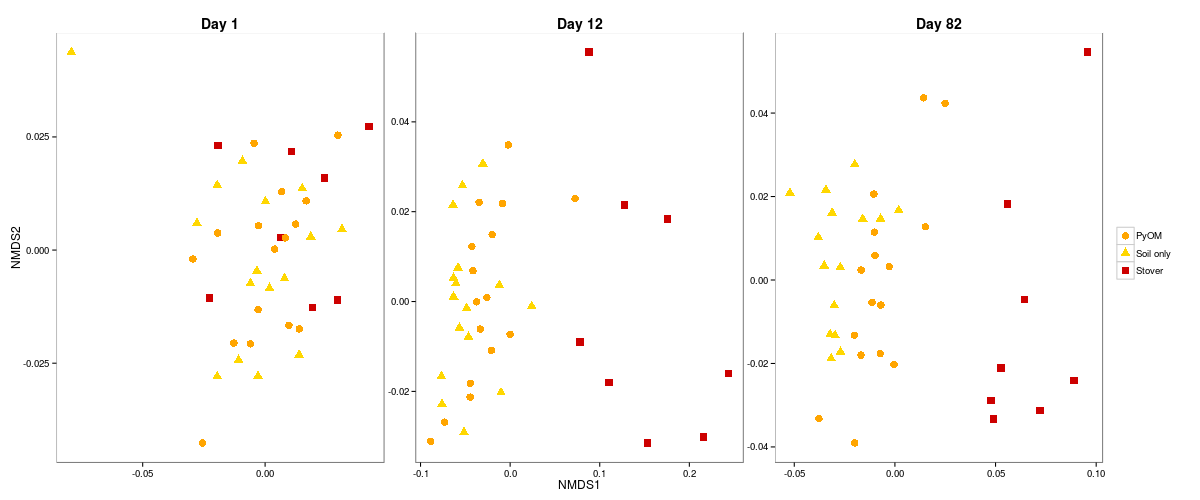

In [45]:
%%R -h 500 -w 1200
D <- ord.NMDS.days
# Sets the relevant ordination

colnames(D)[2:3]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = AmdmtName, shape = AmdmtName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("orange","gold1","red3"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~DayName, scales = "free")
# The axis scales could be all optimized individually
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.byDay = p
p

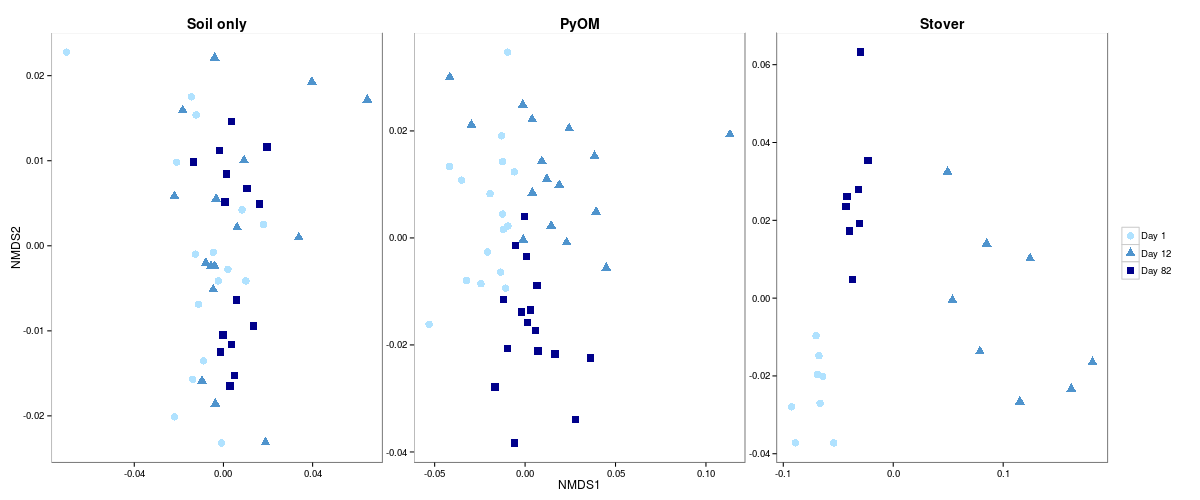

In [47]:
%%R -h 500 -w 1200
D <- ord.NMDS.amdmts
# Sets the relevant ordination

colnames(D)[2:3]<-c("NMDS1","NMDS2")
# Renames the axis columns

D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = DayName, shape = DayName))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("lightskyblue1","steelblue3","blue4"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~AmdmtName, scales = "free")
# The axis scales could be all optimized individually
# p = p + facet_wrap(~strip)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
plot.byAmdmt = p
p

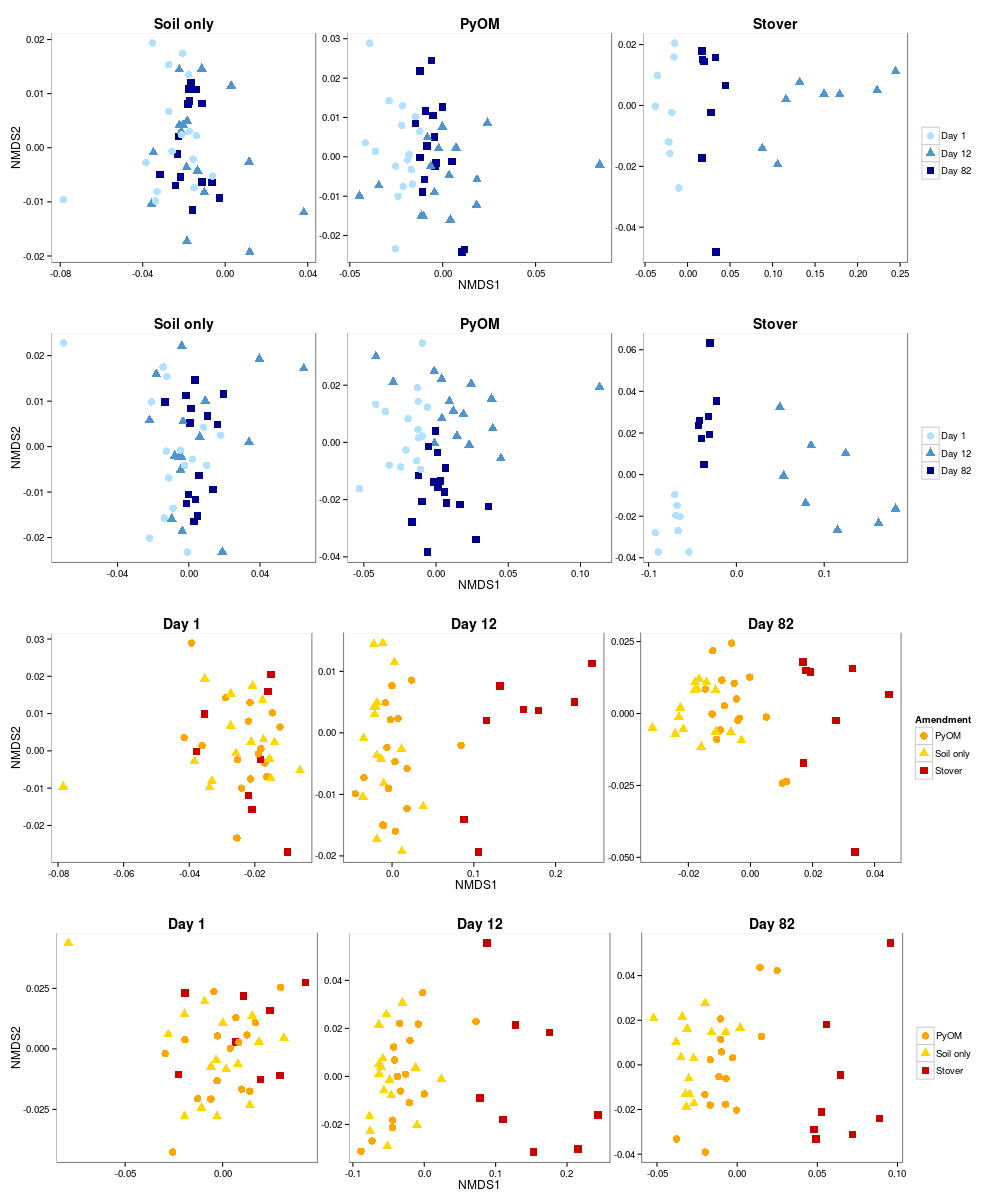

In [53]:
%%R -h 1200 -w 1000
grid.arrange(plot.full.byAmdmt, plot.byAmdmt, plot.full.byDay, plot.byDay, nrow=4)